<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def curva_roc(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()
    #y_hat = [1 if x >= 0.5 else 0 for x in y_hat_prob]
    mask_positive = y_hat_prob >= 0.5
    mask_negative = y_hat_prob < 0.5
    y_hat = y_hat_prob
    y_hat[mask_positive] = 1
    y_hat[mask_negative] = 0
    y_hat = y_hat.astype(int)

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 23.1MB/s]


In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


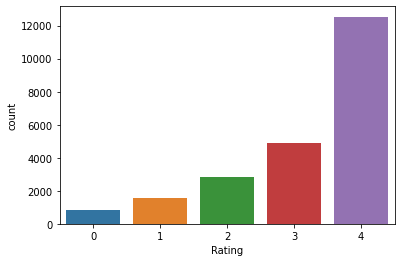

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()
sns.countplot(x='Rating', data=df_reviews)
plt.show()

se observa un desbalance del dataset que luego intentaremos solucionar con algun metodo de oversampling

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)
corpus

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 1372203


In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens) 

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [17]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [18]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [19]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [20]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [21]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['Rating'].values
y = to_categorical(y, num_classes=5)
print(y.shape)

(22641, 5)


In [22]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [24]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [ ]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 156s 333ms/step - loss: 0.4064 - accuracy: 0.5515 - val_loss: 0.3546 - val_accuracy: 0.5744
Epoch 2/50
453/453 [==============================] - 147s 325ms/step - loss: 0.3236 - accuracy: 0.5994 - val_loss: 0.3115 - val_accuracy: 0.6191
Epoch 3/50
453/453 [==============================] - 156s 345ms/step - loss: 0.2953 - accuracy: 0.6350 - val_loss: 0.3132 - val_accuracy: 0.6172
Epoch 4/50
453/453 [==============================] - 145s 321ms/step - loss: 0.2814 - accuracy: 0.6535 - val_loss: 0.3078 - val_accuracy: 0.6219
Epoch 5/50
453/453 [==============================] - 149s 329ms/step - loss: 0.2667 - accuracy: 0.6686 - val_loss: 0.3158 - val_accuracy: 0.6050
Epoch 6/50
453/453 [==============================] - 147s 326ms/step - loss: 0.2561 - accuracy: 0.6824 - val_loss: 0.3238 - val_accuracy: 0.5893
Epoch 7/50
453/453 [==============================] - 145s 320ms/step - loss: 0.2477 - accuracy: 0.6976 - val_loss: 0.3241 -

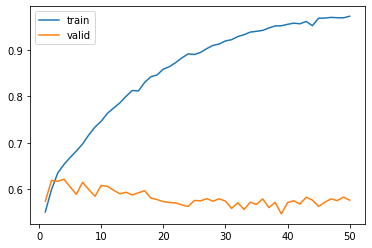

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 13s 94ms/step - loss: 0.9309 - accuracy: 0.5774


[0.9308910965919495, 0.5773901343345642]

claramente el modelo esta haciendo overfitting sobre los datos de train, no consigue generalizar

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [25]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:25<00:00, 115MB/s]


In [26]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [27]:
model_fasttext = FasttextEmbeddings()

In [28]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [29]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

In [30]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [31]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 22s 23ms/step - loss: 0.4077 - accuracy: 0.5520 - val_loss: 0.4019 - val_accuracy: 0.5468
Epoch 2/50
453/453 [==============================] - 9s 20ms/step - loss: 0.3913 - accuracy: 0.5529 - val_loss: 0.3975 - val_accuracy: 0.5468
Epoch 3/50
453/453 [==============================] - 10s 23ms/step - loss: 0.3812 - accuracy: 0.5541 - val_loss: 0.3844 - val_accuracy: 0.5471
Epoch 4/50
453/453 [==============================] - 10s 21ms/step - loss: 0.3753 - accuracy: 0.5584 - val_loss: 0.3860 - val_accuracy: 0.5509
Epoch 5/50
453/453 [==============================] - 11s 25ms/step - loss: 0.3697 - accuracy: 0.5619 - val_loss: 0.3824 - val_accuracy: 0.5531
Epoch 6/50
453/453 [==============================] - 8s 19ms/step - loss: 0.3648 - accuracy: 0.5607 - val_loss: 0.3768 - val_accuracy: 0.5501
Epoch 7/50
453/453 [==============================] - 8s 17ms/step - loss: 0.3612 - accuracy: 0.5664 - val_loss: 0.3717 - val_accuracy: 0.

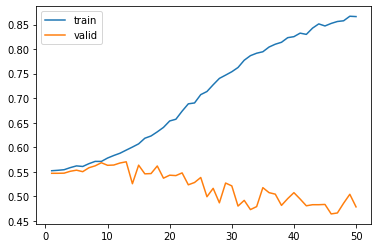

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [33]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 2s 15ms/step - loss: 0.7161 - accuracy: 0.4924


[0.71614009141922, 0.4923824369907379]

en este caso, con embedding de Fasttext, lo mismo que en el caso anterior el modelo hace overfitting

### 4 - Entrenar ambos modelos con Oversampling

In [34]:
from imblearn.over_sampling import RandomOverSampler
ROS = RandomOverSampler(sampling_strategy={0: 5000, 1: 5000, 2: 5000, 3: 5000, 4:10000})
X_train, y_train = ROS.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (10000) in class 4 will be larger than the number of samples in the majority class (class #4 -> 9995)
  f"After over-sampling, the number of samples ({n_samples})"


In [35]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_4 (LSTM)               (None, 115, 64)           29440     
                                                                 
 dropout_4 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [36]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 23s 22ms/step - loss: 0.3660 - accuracy: 0.5670 - val_loss: 0.5474 - val_accuracy: 0.1805
Epoch 2/50
750/750 [==============================] - 19s 25ms/step - loss: 0.2898 - accuracy: 0.6650 - val_loss: 0.4543 - val_accuracy: 0.3392
Epoch 3/50
750/750 [==============================] - 16s 21ms/step - loss: 0.2535 - accuracy: 0.7096 - val_loss: 0.4954 - val_accuracy: 0.3478
Epoch 4/50
750/750 [==============================] - 14s 19ms/step - loss: 0.2322 - accuracy: 0.7334 - val_loss: 0.4200 - val_accuracy: 0.3940
Epoch 5/50
750/750 [==============================] - 16s 21ms/step - loss: 0.2197 - accuracy: 0.7482 - val_loss: 0.4387 - val_accuracy: 0.3813
Epoch 6/50
750/750 [==============================] - 16s 21ms/step - loss: 0.2047 - accuracy: 0.7663 - val_loss: 0.3792 - val_accuracy: 0.5163
Epoch 7/50
750/750 [==============================] - 18s 23ms/step - loss: 0.1977 - accuracy: 0.7722 - val_loss: 0.3512 - val_accuracy:

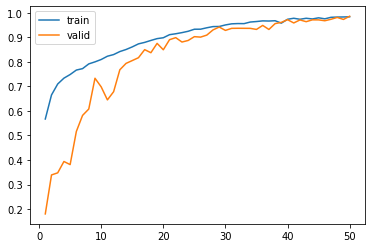

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [38]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 8ms/step - loss: 1.1146 - accuracy: 0.5820


[1.1145721673965454, 0.5820269584655762]

In [39]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_6 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_6 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                

In [40]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 16s 18ms/step - loss: 0.4610 - accuracy: 0.4212 - val_loss: 0.6148 - val_accuracy: 8.3333e-04
Epoch 2/50
750/750 [==============================] - 14s 18ms/step - loss: 0.4265 - accuracy: 0.4836 - val_loss: 0.6624 - val_accuracy: 6.6667e-04
Epoch 3/50
750/750 [==============================] - 16s 21ms/step - loss: 0.4058 - accuracy: 0.5157 - val_loss: 0.5961 - val_accuracy: 0.0257
Epoch 4/50
750/750 [==============================] - 14s 18ms/step - loss: 0.3832 - accuracy: 0.5479 - val_loss: 0.6641 - val_accuracy: 0.0398
Epoch 5/50
750/750 [==============================] - 14s 18ms/step - loss: 0.3608 - accuracy: 0.5785 - val_loss: 0.5741 - val_accuracy: 0.1448
Epoch 6/50
750/750 [==============================] - 16s 22ms/step - loss: 0.3369 - accuracy: 0.6045 - val_loss: 0.5902 - val_accuracy: 0.1418
Epoch 7/50
750/750 [==============================] - 16s 21ms/step - loss: 0.3150 - accuracy: 0.6341 - val_loss: 0.5521 - val_a

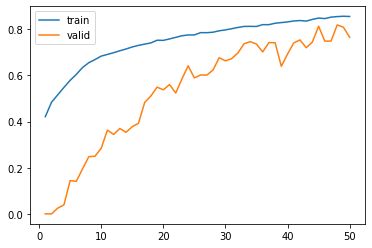

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [41]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 2s 8ms/step - loss: 0.6308 - accuracy: 0.5240


[0.630768895149231, 0.5239567160606384]

### 5 - Conclusion

Al incluir oversampling en los datos de entrada, conseguimos que el modelo haga un fit correcto sobre los mismos, mejorando notablemente respecto a la situacion inicial con los datos desbalanceados. En el caso del modelo 2 (con embedding de fasttext) podriamos seguir corriendo por mas epoch y conseguiriamos mejores metricas aun, en la grafica se observa esta tendencia.